<a href="https://colab.research.google.com/github/tmelo-uea/cursos/blob/main/CursoAnaliseImagensMedicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar pacotes

In [1]:
import os
import numpy as np
import pandas as pd
import pathlib
import imageio
import random

#Explorar datasets

Os conjuntos de dados (datasets) são divididos em três partes: A) treino; B) validação; C) teste.

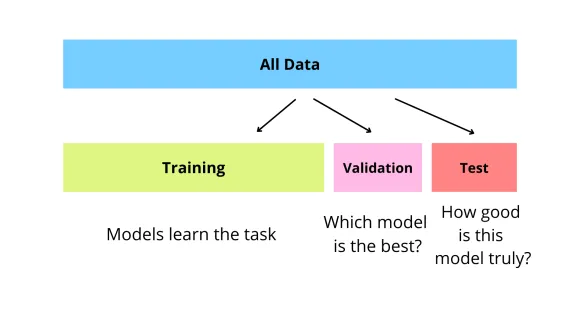

O nosso conjunto de dados é uma representação de imagens de raio-x do pulmão [[link]](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

O nosso conjunto total possui 5.863 imagens.

Cada parte tem um conjunto de imagens normais e com pneumonia.

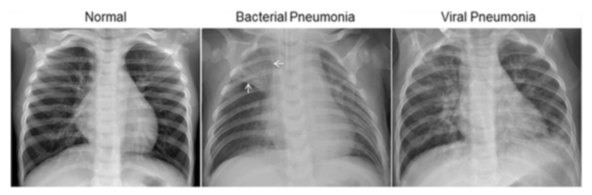

### Código de Leitura dos Dados (Google Drive)

In [2]:
import requests
from PIL import Image
from io import BytesIO
import json
import os

# URL base para a API do GitHub para obter o conteúdo do diretório
api_base_url = 'https://api.github.com/repos/tmelo-uea/cursos/contents/datasets/chest_xray_menor/'

# Função para obter a lista de arquivos em um diretório
def get_file_list(directory_url):
    response = requests.get(directory_url)
    if response.status_code == 200:
        file_list = json.loads(response.content.decode('utf-8'))
        return [file['name'] for file in file_list if file['type'] == 'file']
    else:
        print(f"Falha ao obter conteúdo do diretório: {response.status_code}")
        return []

# Função para baixar uma imagem a partir de uma URL
def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Obter listas de arquivos em cada diretório
train_pneumonia_files = get_file_list(api_base_url + 'train/PNEUMONIA')
train_normal_files = get_file_list(api_base_url + 'train/NORMAL')

test_pneumonia_files = get_file_list(api_base_url + 'test/PNEUMONIA')
test_normal_files = get_file_list(api_base_url + 'test/NORMAL')

val_pneumonia_files = get_file_list(api_base_url + 'val/PNEUMONIA')
val_normal_files = get_file_list(api_base_url + 'val/NORMAL')

# URL base para arquivos brutos
raw_base_url = 'https://raw.githubusercontent.com/tmelo-uea/cursos/main/datasets/chest_xray_menor/'

# Gerar URLs completas das imagens
train_pn = [raw_base_url + 'train/PNEUMONIA/' + filename for filename in train_pneumonia_files]
train_normal = [raw_base_url + 'train/NORMAL/' + filename for filename in train_normal_files]

test_pn = [raw_base_url + 'test/PNEUMONIA/' + filename for filename in test_pneumonia_files]
test_normal = [raw_base_url + 'test/NORMAL/' + filename for filename in test_normal_files]

val_pn = [raw_base_url + 'val/PNEUMONIA/' + filename for filename in val_pneumonia_files]
val_normal = [raw_base_url + 'val/NORMAL/' + filename for filename in val_normal_files]

# Exibir total de imagens
print("Total de imagens:", len(train_pn + train_normal + test_pn + test_normal + val_pn + val_normal))
print("Total de imagens de pneumonia:", len(train_pn + test_pn + val_pn))
print("Total de imagens normais:", len(train_normal + test_normal + val_normal))

Total de imagens: 200
Total de imagens de pneumonia: 100
Total de imagens normais: 100


#Organização dos datasets

In [3]:
train_imgs = train_pn + train_normal
test_imgs = test_pn + test_normal
val_imgs = val_pn + val_normal

#Gerando aleatoriedade nos dados
random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

print ('Treino:', len(train_imgs))
print ('Teste:', len(test_imgs))
print ('Validação:', len(val_imgs))

Treino: 160
Teste: 30
Validação: 10


#Função de pré-processamento das imagens

In [4]:
import cv2 # Importa a biblioteca OpenCV, que é amplamente utilizada para processamento de imagens.
import numpy as np
import requests
from io import BytesIO

img_size = 224 # Define o tamanho para o qual as imagens serão redimensionadas, neste caso 224x224 pixels. Este é um tamanho comum para modelos de redes neurais convolucionais (CNNs).

def download_image(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('L') # Converte para escala de cinza
    return np.array(img)

def preprocess_image(image_list):
    X = [] # imagens
    y = [] # rótulos (0 para normal e 1 para pneumonia)
    count = 0

    for image_url in image_list:
        try:
            # Baixa a imagem da URL
            img = download_image(image_url)

            # Redimensiona a imagem para 224x224 pixels usando interpolação cúbica
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)

            # Converte a imagem de escala de cinza (uma camada) em uma imagem de 3 canais
            img = np.dstack([img, img, img])

            # Converte a imagem de BGR para RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Normaliza a imagem
            img = img.astype(np.float32) / 255.0

            count += 1
            X.append(img)
        except Exception as e:
            print(f'Falha na conversão: {e}')
            continue

        # Obtém os rótulos
        # As imagens são classificadas com base no nome do arquivo: A) Se o nome contém 'NORMAL' ou 'IM', o rótulo é 0 (normal). B) Se o nome contém 'virus' ou 'bacteria', o rótulo é 1 (pneumonia).
        if 'NORMAL' in image_url:
            y.append(0)
        elif 'IM' in image_url:
            y.append(0)
        elif 'virus' in image_url or 'bacteria' in image_url:
            y.append(1)

    return X, y

#Dados de Treino

In [5]:
X, y = preprocess_image(train_imgs)

In [6]:
# Checar todas as imagens de acordo com os rótulos
arr=y
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Valores únicos: " , uniqueValues)
print("Quantidade de ocorrências: ", occurCount)

Valores únicos:  [0 1]
Quantidade de ocorrências:  [80 80]


### Visualização de algumas imagens de dados de treino

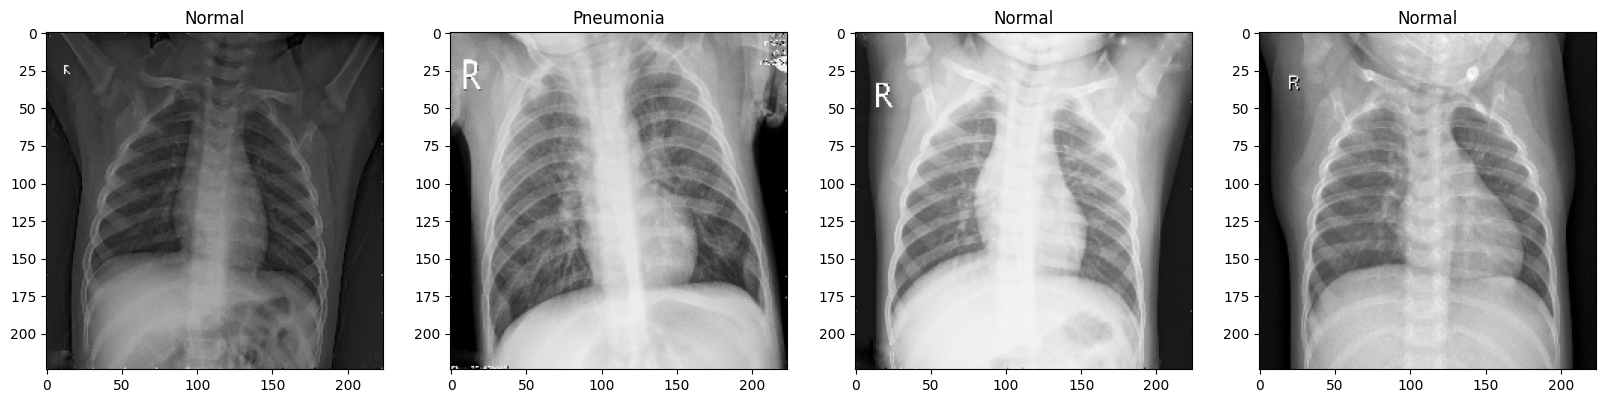

In [7]:
#Mostrar algumas imagens de dados de treino
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(X[i])
    k=k+1;

#Dados de teste

In [8]:
# Pegar os rótulos para o conjunto de teste
P, t = preprocess_image(test_imgs)

In [9]:
arr=t
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Valores únicos: " , uniqueValues)
print("Quantidade de ocorrências: ", occurCount)

Valores únicos:  [0 1]
Quantidade de ocorrências:  [15 15]


### Visualizar algumas imagens de dados de teste

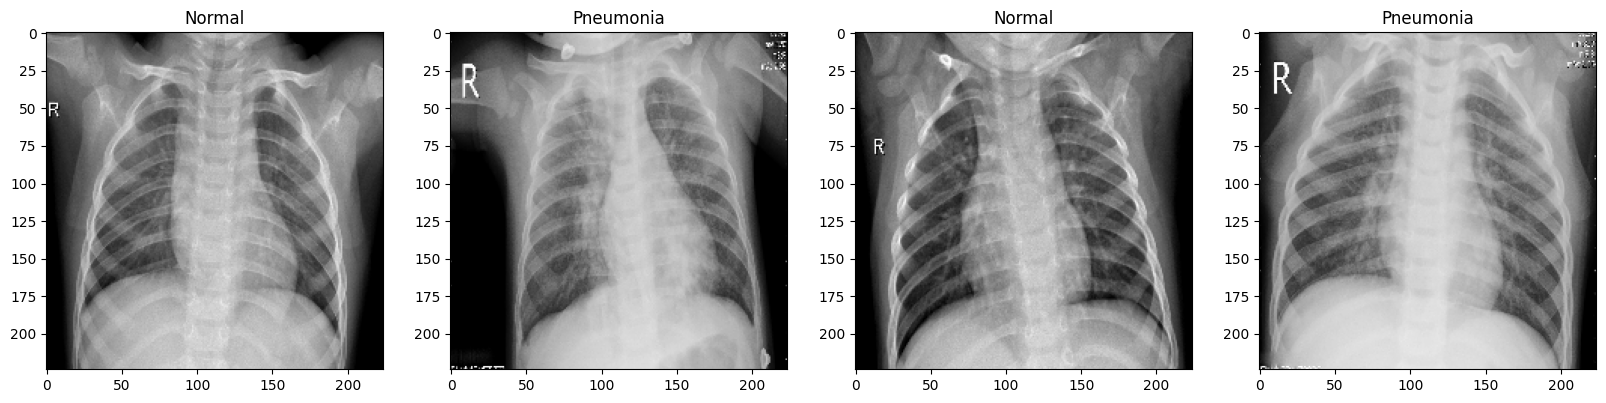

In [10]:
#Mostrar os dados de teste

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (t[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(P[i])
    k=k+1;

#Dados de validação

In [11]:
#Pegar os rótulos
K, m = preprocess_image(val_imgs)

In [12]:
arr=m

uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Valores únicos: " , uniqueValues)
print("Quantidade de ocorrências: ", occurCount)

Valores únicos:  [0 1]
Quantidade de ocorrências:  [5 5]


### Visualizar algumas imagens de validação

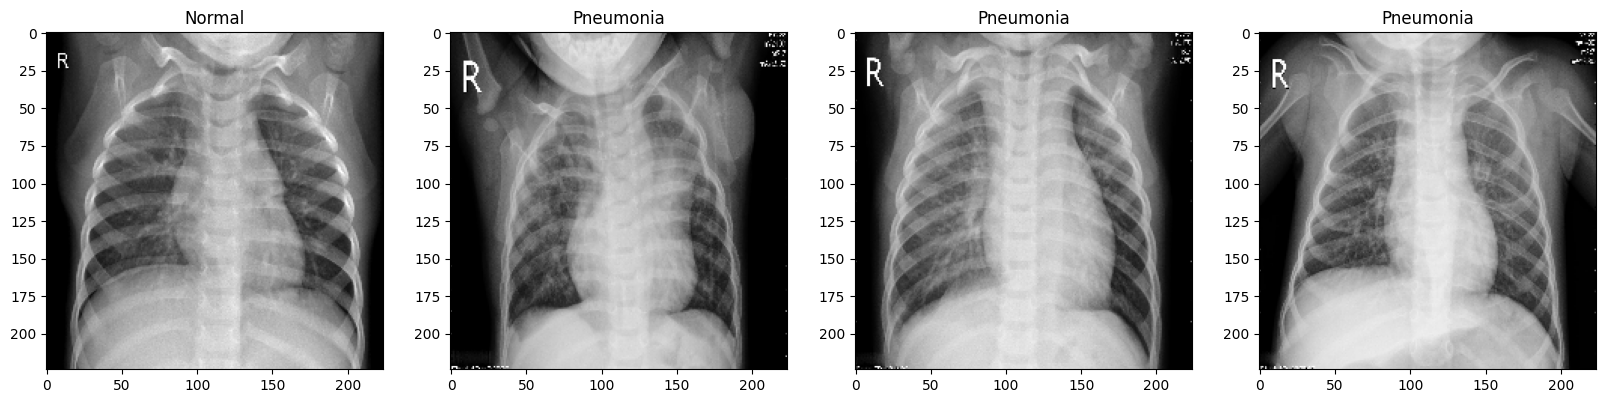

In [13]:
#Mostrar o conjunto de validação

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (m[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(K[i])
    k=k+1;

#Gráfico de distribuição de dados

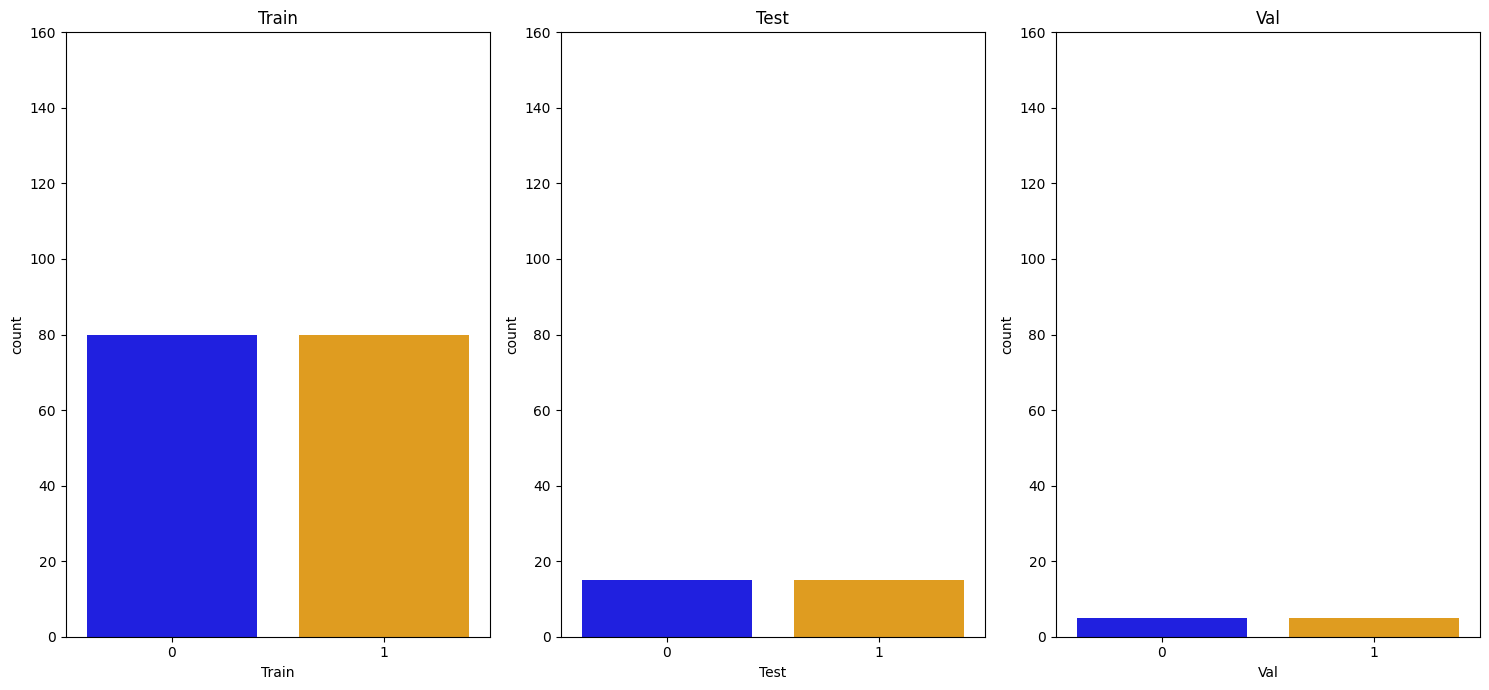

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Criando DataFrames separados
df_train = pd.DataFrame({'Train': y})
df_test = pd.DataFrame({'Test': t})
df_val = pd.DataFrame({'Val': m})

# Convertendo valores inteiros para strings para correspondência correta
df_train['Train'] = df_train['Train'].astype(str)
df_test['Test'] = df_test['Test'].astype(str)
df_val['Val'] = df_val['Val'].astype(str)

# Configurando a visualização
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

# Cores para os valores '0' e '1'
palette = {'0': 'blue', '1': 'orange'}

# Plotando os dados de treino com cores específicas
sns.countplot(x='Train', hue='Train', data=df_train, ax=ax[0], palette=palette, legend=False)
ax[0].set_title('Train')
ax[0].set_ylim(0, len(df_train))  # Ajuste conforme necessário para melhor visualização

# Plotando os dados de teste com cores específicas
sns.countplot(x='Test', hue='Test', data=df_test, ax=ax[1], palette=palette, legend=False)
ax[1].set_title('Test')
ax[1].set_ylim(0, len(df_train))  # Ajuste conforme necessário para melhor visualização

# Plotando os dados de validação com cores específicas
sns.countplot(x='Val', hue='Val', data=df_val, ax=ax[2], palette=palette, legend=False)
ax[2].set_title('Val')
ax[2].set_ylim(0, len(df_train))  # Ajuste conforme necessário para melhor visualização

plt.tight_layout()
plt.show()

### Lidar com o cálculo de pesos das classes

In [15]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y = np.array(y)  # Garantindo que 'y' é um array numpy, ajuste conforme necessário

# Verificando a versão do sklearn e ajustando a função compute_class_weight
try:
    # Tentativa de usar a função compute_class_weight se disponível
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(enumerate(class_weights))
except AttributeError:
    # Se compute_class_weight foi descontinuada, usando uma alternativa
    from sklearn.utils import compute_sample_weight
    class_weights = compute_sample_weight(class_weight='balanced', y=y)
    unique_classes = np.unique(y)
    class_weights = {cls: np.mean(class_weights[y == cls]) for cls in unique_classes}

print(class_weights)

{0: 1.0, 1: 1.0}


#Distribuição dos dados de treino, validação e testes

In [16]:
import seaborn as sns
import gc

train_imgs = train_pn+ train_normal
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(P)
y_test = np.array(t)
X_val = np.array(K)
y_val = np.array(m)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(160, 224, 224, 3)
(160,)
(30, 224, 224, 3)
(30,)
(10, 224, 224, 3)
(10,)


###Limpar a memória

In [17]:
#Limpar a memória
del X
del y
gc.collect()

0

A variável **batch_size** no contexto do processamento digital de imagens médicas usando redes neurais representa o número de amostras de dados que serão processadas em conjunto durante uma única iteração de treinamento.

Neste caso, o batch_size é definido como 32, o que significa que a rede neural irá processar 32 imagens de uma vez antes de atualizar os parâmetros do modelo.

In [18]:
#Pegar o tamanho dos dados de treino e validação
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

#Treino da rede neural

A classe **ImageDataGenerator** do **Keras**, que é usada para aumentar o tamanho do conjunto de dados de treinamento e validação por meio da geração de imagens modificadas.

In [19]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)

val_datagen = ImageDataGenerator(zoom_range=0.45)

Treinamento (train_datagen)

*    rotation_range: Define o intervalo, em graus, dentro do qual as imagens serão rotacionadas aleatoriamente. Neste caso, 7 graus.
*    width_shift_range: Permite um deslocamento horizontal aleatório das imagens como uma fração do total da largura da imagem, aqui definido como 0.05 (5%).
*    height_shift_range: Permite um deslocamento vertical aleatório das imagens como uma fração do total da altura da imagem, também definido como 0.05 (5%).
*    shear_range: Aplica uma translação de cisalhamento aleatória às imagens. 0.2 indica o ângulo em graus que as imagens podem ser distorcidas.
*    zoom_range: Permite que as imagens sejam aleatoriamente ampliadas ou reduzidas por um fator especificado, neste caso, até 0.45 (45%).
*    horizontal_flip: Habilita o espelhamento horizontal aleatório das imagens.
*    zoom_range: Este é o único parâmetro aplicado ao gerador de dados de validação, com o mesmo fator de até 0.45 para o zoom. Isso indica que as imagens de validação podem ser ampliadas ou reduzidas aleatoriamente pelo mesmo fator.

In [20]:
#Criar os geradores de imagens
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [21]:
#Definir o tamanho das imagens
img_size = 224

In [22]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras import backend as K

base_model = MobileNet(weights=None, include_top=False,input_shape=(img_size, img_size, 3))

x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

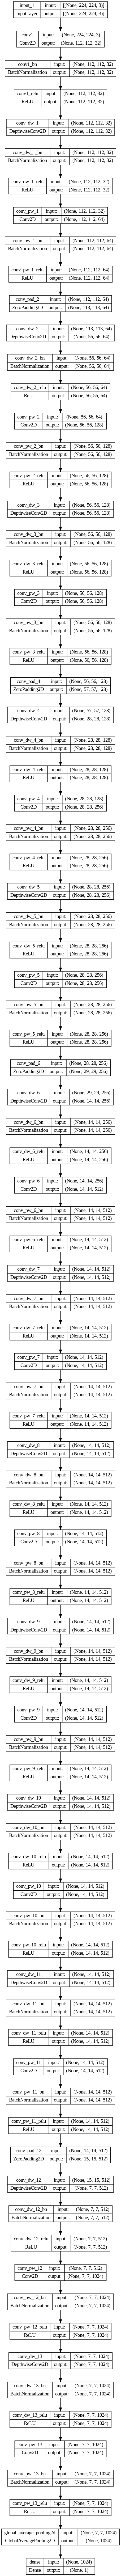

In [23]:
from tensorflow.keras.utils import plot_model

# Visualizar a arquitetura do modelo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#Nós podemos ver os detalhes da arquitetura MobileNet
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

* **steps_per_epoch**: Esse valor determina o número de lotes de amostras a serem usados em cada época de treinamento.
* **validation_steps**: Similar ao steps_per_epoch, mas para o conjunto de validação.

In [25]:
# Calculando os valores corretos para steps_per_epoch e validation_steps
steps_per_epoch = max(1, ntrain // batch_size)
validation_steps = max(1, nval // batch_size)

# Usando Model.fit com um gerador
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weights
)

Epoch 1/10
5/5 [==============================] - 21s 400ms/step - loss: 0.7585 - binary_accuracy: 0.5000 - mae: 0.4835 - val_loss: 0.6934 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 2/10
5/5 [==============================] - 4s 981ms/step - loss: 0.6559 - binary_accuracy: 0.6250 - mae: 0.4307 - val_loss: 0.6942 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 3/10
5/5 [==============================] - 2s 382ms/step - loss: 0.5161 - binary_accuracy: 0.7750 - mae: 0.3237 - val_loss: 0.6958 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 4/10
5/5 [==============================] - 2s 379ms/step - loss: 0.5233 - binary_accuracy: 0.7437 - mae: 0.3295 - val_loss: 0.6994 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 5/10
5/5 [==============================] - 2s 387ms/step - loss: 0.4436 - binary_accuracy: 0.8062 - mae: 0.2915 - val_loss: 0.7072 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 6/10
5/5 [==============================] - 2s 386ms/step - los

#Plotar gráfico de treinamento e validação

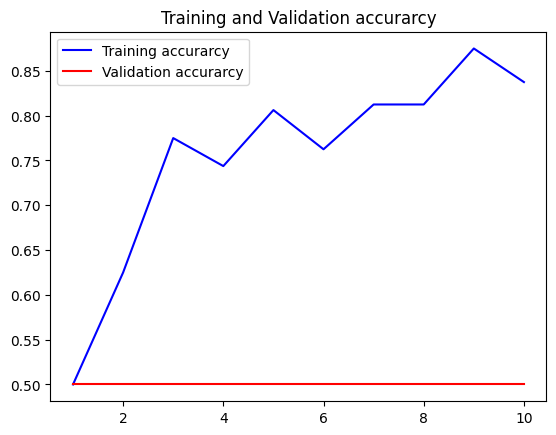

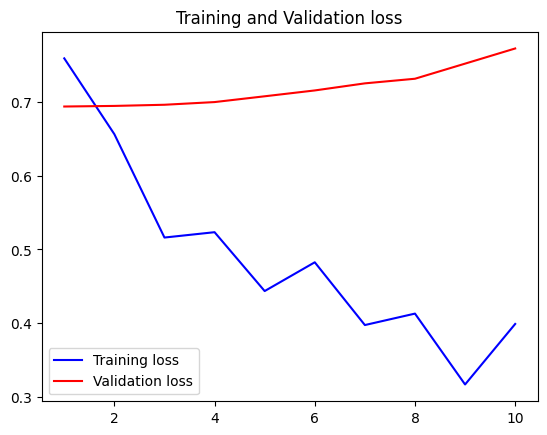

In [26]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Treino e validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Treino e validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('MATRIZ DE CONFUSÃO ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Acurácia: {}%'.format(acc))
print('Precisão: {}%'.format(precision))
print('Revocação: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nMÉTRICA DE TREINO ----------------------')
print('Treino acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

1/1 [==============================] - 1s 1s/step
MATRIZ DE CONFUSÃO ------------------
[[15  0]
 [15  0]]

============TEST METRICS=============
Acurácia: 50.0%
Precisão: nan%
Revocação: 0.0%
F1-score: nan

MÉTRICA DE TREINO ----------------------
Treino acc: 83.75


<ipython-input-27-f334d669debb>:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)*100


#Matriz de confusão

<Axes: >

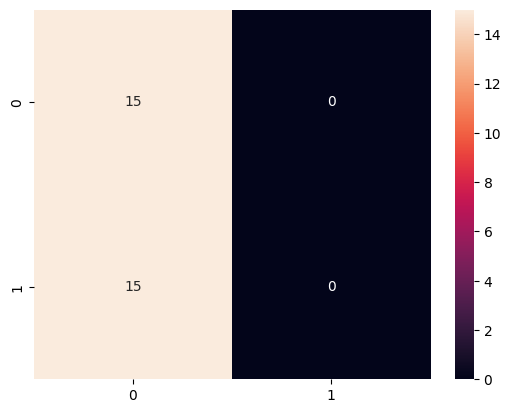

In [28]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

#Curva ROC (Curva Característica de Operação do Receptor)

A curva ROC é uma ferramenta valiosa para visualizar o desempenho de um modelo de classificação em todas as classificações de limiar possíveis, com a AUC proporcionando uma medida única de qualidade do modelo, independentemente de um limiar específico.

Uma AUC de 1.0 indica um modelo perfeito, enquanto uma AUC de 0.5 indica um desempenho não melhor que o acaso.

AUC Score: 0.5


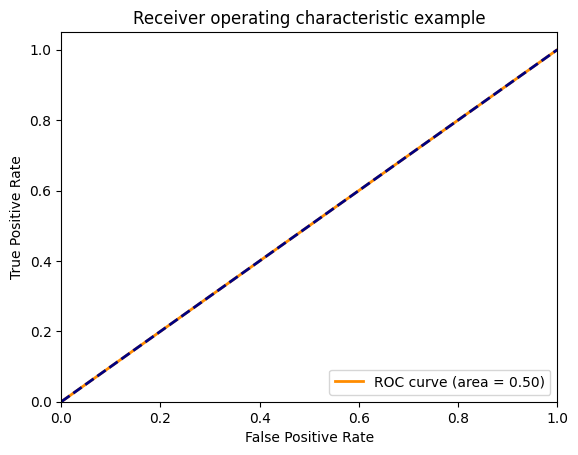

In [29]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Exercícios



*   Execute o mesmo código com o conjunto completo de imagens e faça uma comparação do resultado com o conjunto menor de imagens.
*   Modifique o número de épocas com o mesmo conjunto de dados e análise o novo resultado.
*   Explique a importância do pré-processamento de imagens em tarefas de análise de imagens médicas.
*   Quais métricas são comumente utilizadas para avaliar a performance de um modelo de classificação de imagens?
*   Explique o que é uma matriz de confusão e como ela pode ser utilizada para analisar a performance de um modelo.
